In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ast
import re
from scipy.stats import chi2_contingency
from helper_function import *
import pandas as pd
from IPython.display import display, HTML


In [2]:
df = pd.read_csv('astronauts_with_roles_final.csv')
df_roles = pd.read_csv('astronauts_with_roles.csv')
df['degrees'] = df['degrees'].apply(convert_to_list)
df['occupations'] = df['occupations'].apply(convert_to_list)
df['education'] = df['education'].apply(convert_to_list)
df['interests'] = df['interests'].apply(convert_to_list)


<Axes: xlabel='Mission.Role', ylabel='count'>

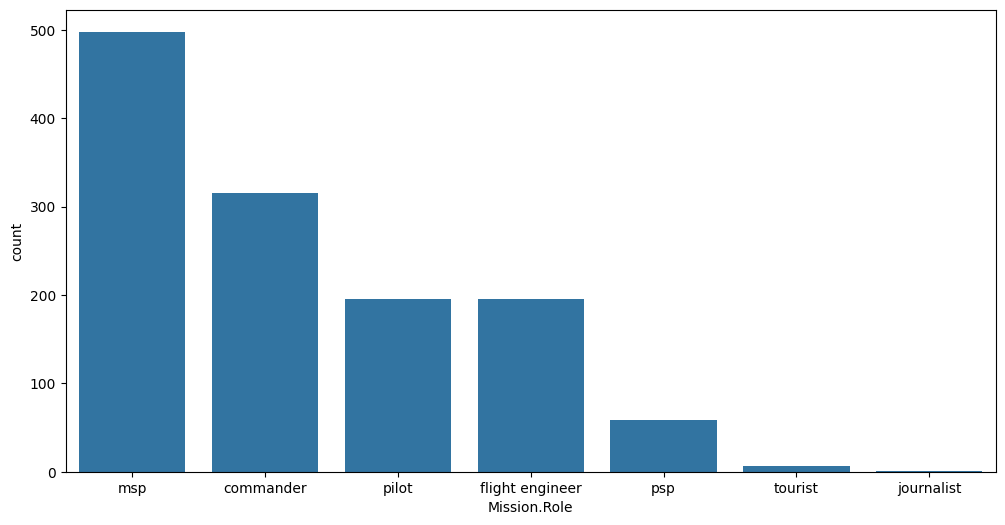

In [3]:
plt.figure(figsize=(12, 6))
sns.countplot(x = 'Mission.Role', data = df_roles, order = df_roles['Mission.Role'].value_counts().index)

Study relationship between roles and degrees

In [4]:
df_degrees = pd.read_csv('astronauts_with_degree_level.csv')[['name', 'degrees']]
df_degrees['degrees'] = df_degrees['degrees'].apply(convert_degree_to_list)
df_degrees  = pd.merge(df_roles, df_degrees, left_on='cleaned_name', right_on='name', how='inner').explode('degrees').reset_index(drop=True).dropna()
df_degrees['degrees'] = df_degrees['degrees'].apply(find_degree_level)
df_degrees = df_degrees[df_degrees['degrees'].isna() == False]
degree_order = ['bachelor', 'master', 'doctor']
# Map degree to its order for sorting
degree_rank = {deg: i for i, deg in enumerate(degree_order)}

# Sort by cleaned_name and degree rank, then drop duplicates keeping the highest degree
df_degrees_sorted = df_degrees.copy()
df_degrees_sorted['degree_rank'] = df_degrees_sorted['degrees'].map(degree_rank)
df_degrees_sorted = df_degrees_sorted.sort_values(['cleaned_name', 'degree_rank'], ascending=[True, False])
df_degrees_unique = df_degrees_sorted.drop_duplicates(subset=['cleaned_name', "Mission.Role"], keep='first').drop(columns='degree_rank')


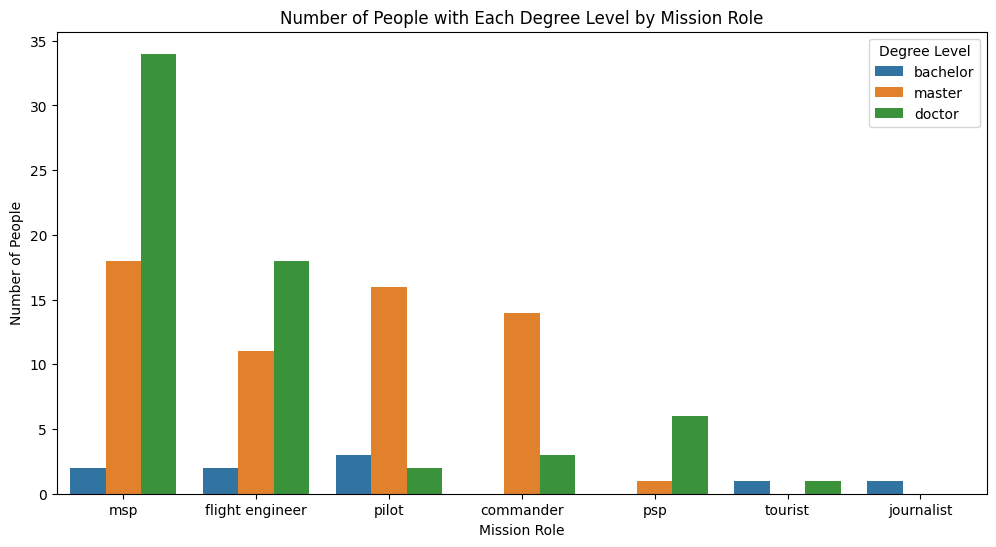

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(
    x='Mission.Role',
    hue='degrees',
    data=df_degrees_unique,
    order=df_degrees_unique['Mission.Role'].unique(),
    hue_order=degree_order
)
plt.xlabel('Mission Role')
plt.ylabel('Number of People')
plt.title('Number of People with Each Degree Level by Mission Role')
plt.legend(title='Degree Level')
plt.show()

In [6]:
contingency_table = pd.crosstab(df_degrees_unique['degrees'], df_degrees_unique['Mission.Role'])
chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print(f"Degree (Chi-Squared Statistic): {chi2:.4f}")
print(f"Degree (P-value): {p_value:.4f}")


n_deg = contingency_table.sum().sum()
cramers_v_deg = np.sqrt(chi2 / (n_deg * (min(contingency_table.shape)-1)))
print(f"\nCramer's V: {cramers_v_deg:.4f}")
if cramers_v_deg < 0.1:
    print("-> Weak Association.")
elif cramers_v_deg < 0.3:
    print("-> Moderate Association.")
else:
    print("-> Strong Association.")

Degree (Chi-Squared Statistic): 52.7790
Degree (P-value): 0.0000

Cramer's V: 0.4454
-> Strong Association.


In [7]:
major_df = pd.read_csv('astronauts_with_major.csv')

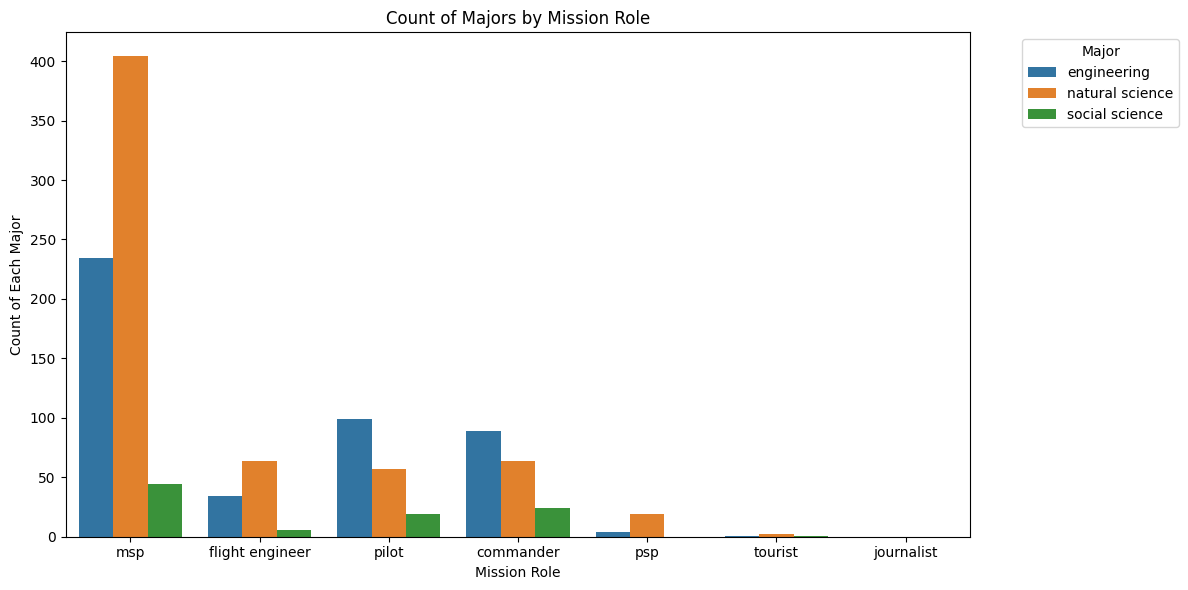

In [8]:
plt.figure(figsize=(12, 6))
sns.countplot(
    x='Mission.Role',
    hue='major category',
    data=major_df,
    order=major_df['Mission.Role'].unique()
)
plt.xlabel('Mission Role')
plt.ylabel('Count of Each Major')
plt.title('Count of Majors by Mission Role')
plt.legend(title='Major', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:

contingency_table = pd.crosstab(major_df['major category'], major_df['Mission.Role'])

chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print(f"Major (Chi-Squared Statistic): {chi2:.4f}")
print(f"Major (P-value): {p_value:.4f}")

n_deg = contingency_table.sum().sum()
cramers_v_deg = np.sqrt(chi2 / (n_deg * (min(contingency_table.shape)-1)))
print(f"\nCramer's V: {cramers_v_deg:.4f}")
if cramers_v_deg < 0.1:
    print("-> Weak association.")
elif cramers_v_deg < 0.3:
    print("-> Moderate association.")
else:
    print("-> Strong association.")

Major (Chi-Squared Statistic): 75.2872
Major (P-value): 0.0000

Cramer's V: 0.1798
-> Moderate association.


Study relationship between roles and hobbies

In [10]:
df_interest_with_category = pd.read_csv('astronauts_interests.csv')

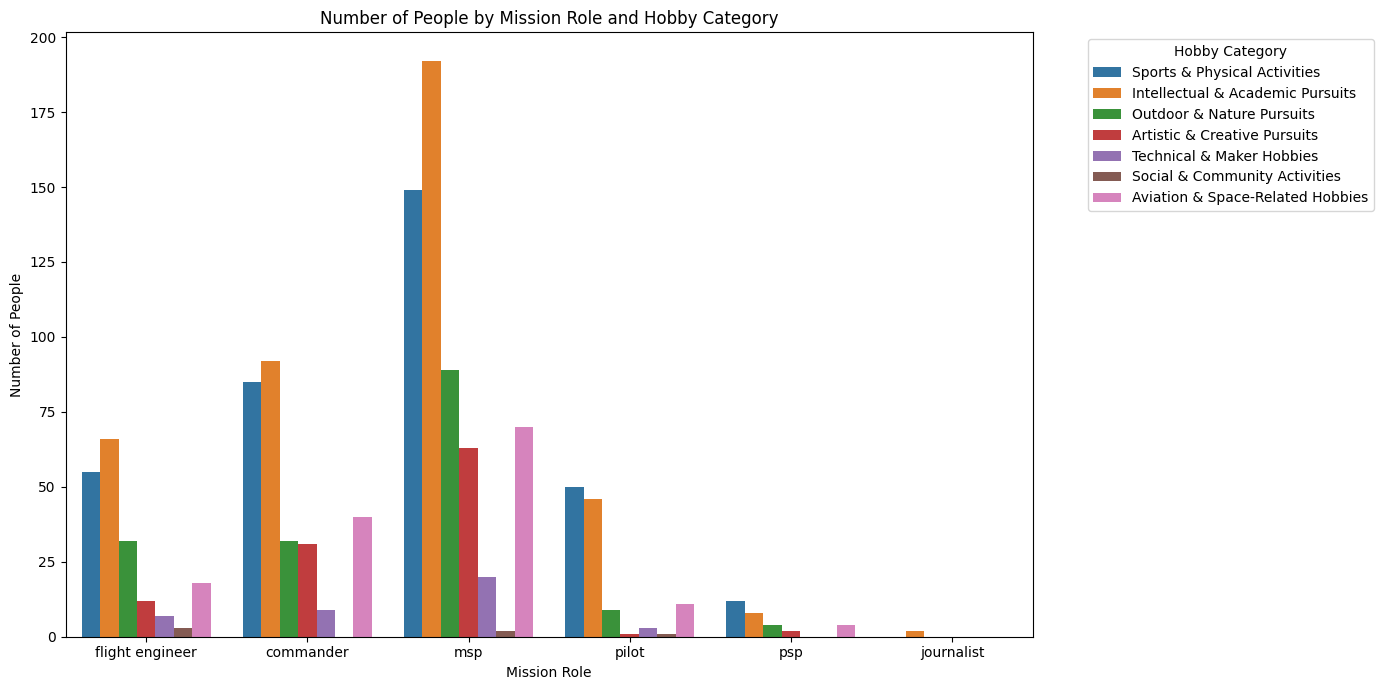

In [11]:
plt.figure(figsize=(14, 7))
sns.countplot(
    x='Mission.Role',
    hue='Hobby Category (Recategorized)',
    data=df_interest_with_category,
    order=df_interest_with_category['Mission.Role'].unique()
)
plt.xlabel('Mission Role')
plt.ylabel('Number of People')
plt.title('Number of People by Mission Role and Hobby Category')
plt.legend(title='Hobby Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
contingency_table = pd.crosstab(df_interest_with_category['Hobby Category (Recategorized)'], df_interest_with_category['Mission.Role'])

chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print(f"Hobby (Chi-Squared Statistic): {chi2:.4f}")
print(f"Hobby (P-value): {p_value:.4f}")

n_deg = contingency_table.sum().sum()
cramers_v_deg = np.sqrt(chi2 / (n_deg * (min(contingency_table.shape)-1)))
print(f"\nCramer's V: {cramers_v_deg:.4f}")
if cramers_v_deg < 0.1:
    print("-> Weak Association.")
elif cramers_v_deg < 0.3:
    print("-> Moderate Association.")
else:
    print("-> Strong Association.")

Hobby (Chi-Squared Statistic): 47.4842
Hobby (P-value): 0.0223

Cramer's V: 0.0882
-> Weak Association.


Study relationship between roles and schools

In [13]:
df_education = df.drop(columns=['degrees','occupations','interests'], axis=1).explode('education').reset_index(drop=True).dropna()
df_education['institution'] = df_education['education'].apply(get_institution_from_dict)
df_education = df_education.drop(columns=['education'])


In [14]:

institution_counts = df_education['institution'].value_counts().sort_values(ascending=False)

top_institutions = institution_counts.head(15).reset_index()
top_institutions.columns = ['Institution', 'Count']

# Use pandas styling for a beautiful table
styled_table = top_institutions.style.set_properties(**{
    'background-color': '#f9f9f9',
    'color': '#333',
    'border-color': 'black',
    'border-width': '1px',
    'border-style': 'solid'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4F81BD'), ('color', 'white'), ('font-weight', 'bold')]}
]).set_caption("Top 15 Institutions by Astronaut Count")
display(styled_table)

,Institution,Count
0,Massachusetts Institute of Technology,62
1,United States Naval Academy,60
2,United States Air Force Academy,60
3,Purdue University,49
4,Stanford University,40
5,Rice University,28
6,Naval Postgraduate School,27
7,University of Washington,25
8,U.S. Naval Postgraduate School,23
9,Moscow Aviation Institute,22
